In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [72]:
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [14]:
meta = pd.DataFrame(train.columns[2:])

In [22]:
meta['up'] = train.iloc[:,2:].quantile(0.90).values
meta['down'] = train.iloc[:,2:].quantile(0.10).values
meta = meta.set_index(0)

In [65]:
for col in train.columns[2:]:
    train[col].loc[train[col] < meta.loc[col].down] = meta.loc[col].down
    train[col].loc[train[col] > meta.loc[col].up] = meta.loc[col].up

In [74]:
target = train.target

# LGB

In [76]:
# https://www.kaggle.com/fayzur/customer-transaction-prediction-strong-baseline
# Thanks fayzur. Nice Parameter 
param = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': -1,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [77]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
#     predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.916222	valid_1's auc: 0.878348
Early stopping, best iteration is:
[4671]	training's auc: 0.929973	valid_1's auc: 0.87952
CV score: 0.87952 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.916485	valid_1's auc: 0.876687
Early stopping, best iteration is:
[4619]	training's auc: 0.929777	valid_1's auc: 0.877816
CV score: 0.87782 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.914826	valid_1's auc: 0.885042


KeyboardInterrupt: 

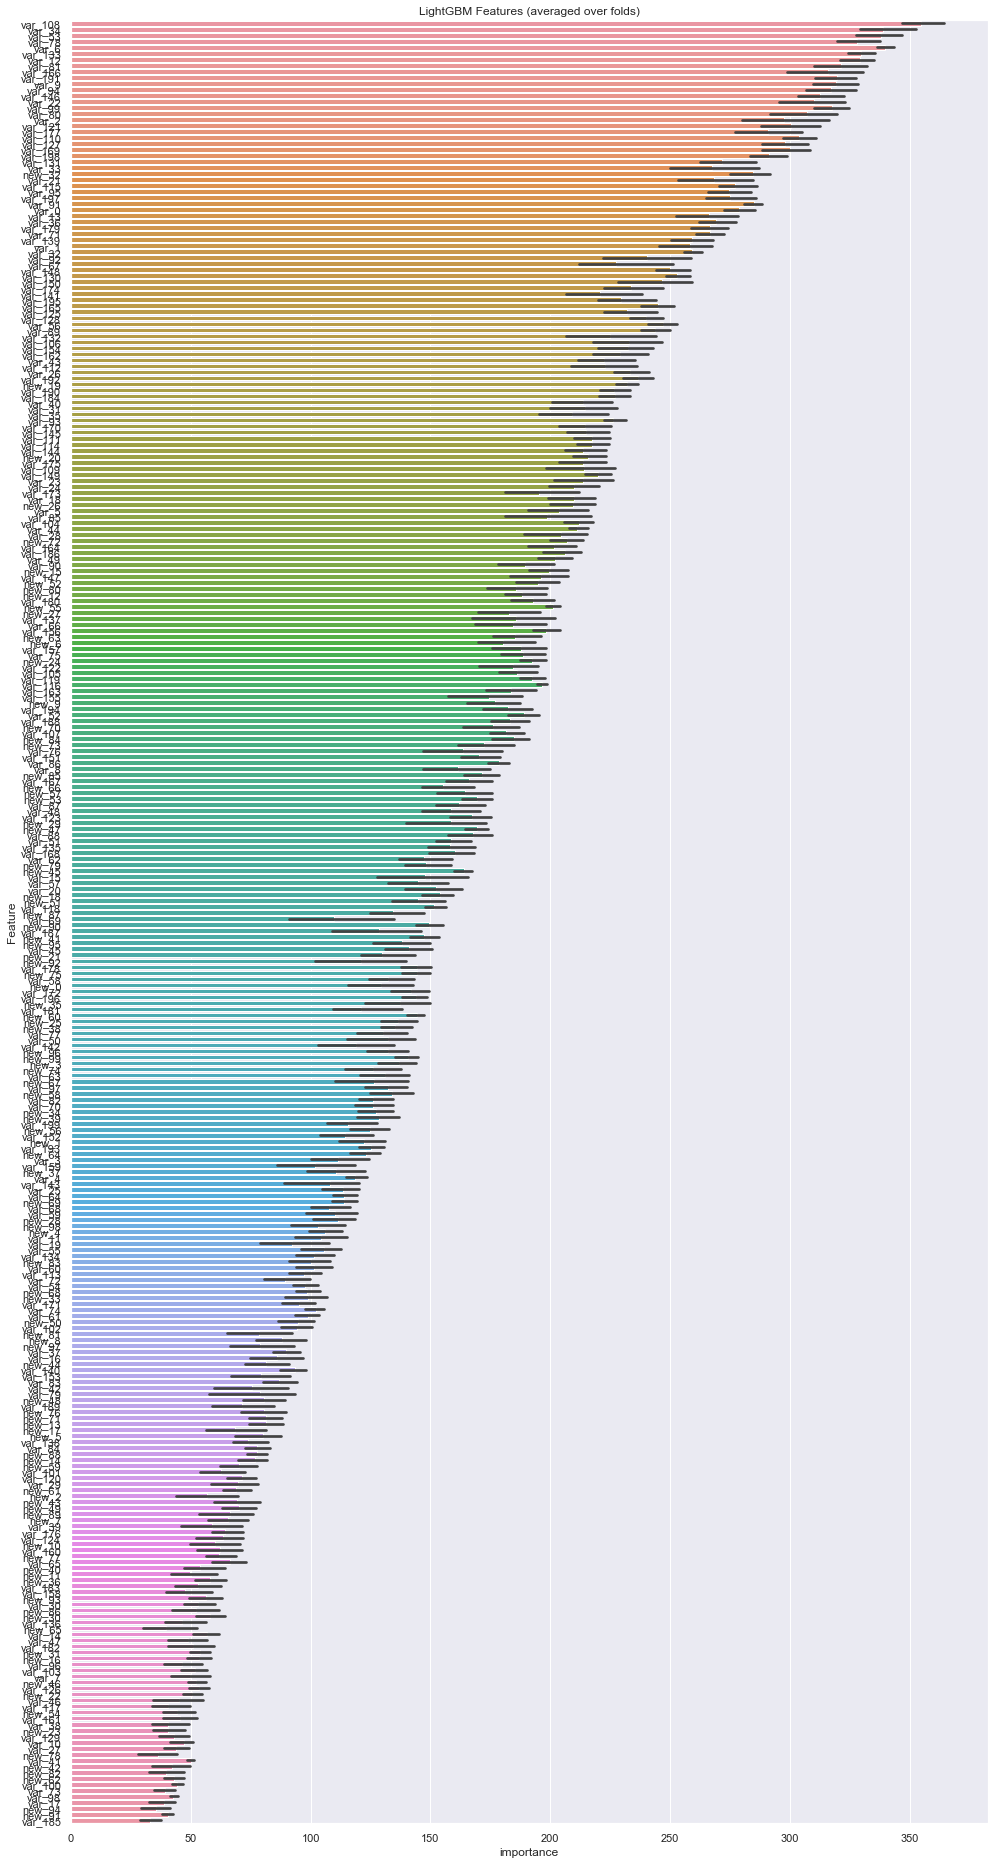

In [55]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()